<a href="https://colab.research.google.com/github/emartinmorgan/OPPlogfileanalysis/blob/main/logpreg_sankey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##load packages

In [ ]:
# !pip install chart_studio
import pandas as pd
import numpy as np
# import chart_studio.plotly as cspy
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
# import chart_studio.plotly as py
import plotly.graph_objects as go

import plotly.express as px
# import chart_studio.plotly as py
import plotly

import seaborn as se
from google.colab import files
# print("hello world")

## prelim analysis

In [ ]:
all = pd.read_csv("/content/drive/MyDrive/OSU - BMI/Fareed Lab/Thesis/Data_Final/Sankey/sank_all_fin.csv")
all

,pat_epi,clus_all_id,clus_all,tri
0,1.1,1.0,Prepared Engagers,1
1,3.1,2.0,Intense Digital Engagers,1
2,5.1,3.0,Average Users,1
3,8.1,4.0,Average Users,1
4,13.1,5.0,Prepared Engagers,1
...,...,...,...,...
30651,17404.1,7657.0,Average Users,4
30652,17405.1,7658.0,Average Users,4
30653,17406.1,7659.0,Schedulers,4
30654,17407.1,7660.0,Prepared Engagers,4


([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text major ticklabel objects>)

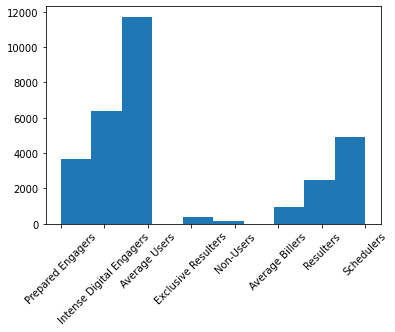

In [ ]:
plt.hist(all.clus_all,bins=10)
plt.xticks(rotation = 45)

In [ ]:
# Based on the tri, we can compute the rank of each cluster at the pat_epi level:

# a) Sort ascendingly per pat_epi and tri

all.sort_values(['pat_epi', 'tri'],
                 ascending=[True, True], inplace=True)
all.head()

,pat_epi,clus_all_id,clus_all,tri
0,1.1,1.0,Prepared Engagers,1
7664,1.1,1.0,Average Users,2
15328,1.1,1.0,Average Users,3
22992,1.1,1.0,Average Users,4
1,3.1,2.0,Intense Digital Engagers,1


In [ ]:
all=all[all.tri!=4]

In [ ]:
# b) Define a ranking function based on tri, using the method = 'first' param to ensure no clusters have the same rank

# def rank(x): return x['tri'].rank(method='first').astype(int)

# c) Group by user_id 
grouped = all.groupby('pat_epi')

# d) Apply the ranking function to the all DF into a new "rank_clus" column
# all["rank_clus"] = grouped.apply(rank).reset_index(0, drop=True)

# e) The shift function allows to access the next row's data. Here, we'll want the cluster name
def get_next_clus(x): return x['clus_all'].shift(-1)

# f) Apply the function into a new "next_clus" column
all["next_clus"] = grouped.apply(
     lambda x: get_next_clus(x)).reset_index(0, drop=True)

# g) Regroup by user_id 
grouped = all.groupby('pat_epi')
all.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,pat_epi,clus_all_id,clus_all,tri,next_clus
0,1.1,1.0,Prepared Engagers,1,Average Users
7664,1.1,1.0,Average Users,2,Average Users
15328,1.1,1.0,Average Users,3,NaN
1,3.1,2.0,Intense Digital Engagers,1,Average Billers
7665,3.1,2.0,Average Billers,2,Schedulers


We attribute a unique color to each event, and name this dict nodes_dict.

In [ ]:
# Working on the nodes_dict

all_clus = list(all.clus_all.unique())

# Create a set of colors that you'd like to use in your plot.
palette = ['50BE97', 'E4655C', 'FBEEAC', '3E5066',
           'BFD6DE', 'FCC865', '353A3E', 'E6E6E6']
#  Here, I passed the colors as HEX, but we need to pass it as RGB. This loop will convert from HEX to RGB:
for i, col in enumerate(palette):
    palette[i] = tuple(int(col[i:i+2], 16) for i in (0, 2, 4))

# Append a Seaborn complementary palette to your palette in case you did not provide enough colors to style every event
# complementary_palette = se.color_palette("deep", len(all_events) - len(palette))
# if len(complementary_palette) > 0:
#     palette.extend(complementary_palette)

output = dict()
output.update({'nodes_dict': dict()})

i = 0
for tri in all.tri.unique(): # For each tri of clus...
    # Create a new key equal to the tri...
    output['nodes_dict'].update(
        {tri: dict()}
    )
    
    # Look at all the events that were done at this step of the funnel...
    all_clus_at_this_tri = all[all.tri ==
                                   tri].clus_all.unique()
    
    # Read the colors for these events and store them in a list...
    tri_palette = []
    for clus in all_clus_at_this_tri:
        tri_palette.append(palette[list(all_clus).index(clus)])
    
    # Keep trace of the events' names, colors and indices.
    output['nodes_dict'][tri].update(
        {
            'sources': list(all_clus_at_this_tri),
            'color': tri_palette,
            'sources_index': list(range(i, i+len(all_clus_at_this_tri)))
        }
    )
    # Finally, increment by the length of this rank's available clus to make sure next indices will not be chosen from existing ones
    i += len(output['nodes_dict'][tri]['sources_index'])

In [ ]:
all_clus_at_this_tri

array(['Average Users', 'Schedulers', 'Intense Digital Engagers',
       'Resulters', 'Non-Users'], dtype=object)

##prep data

In [ ]:
# Working on the links_dict

output.update({'links_dict': dict()})

# Group the DataFrame by pat_epi and tri
grouped = all.groupby(['pat_epi', 'tri'])

# Define a function to read the souces, targets, values clus_all to next_clus:
def update_source_target(user):
    try:
        # user.name[0] is the user's pat_epi; user.name[1] is the tri
        # 1st we retrieve the source and target's indices from nodes_dict
        source_index = output['nodes_dict'][user.name[1]]['sources_index'][output['nodes_dict']
                                                                           [user.name[1]]['sources'].index(user['clus_all'].values[0])]
        target_index = output['nodes_dict'][user.name[1] + 1]['sources_index'][output['nodes_dict']
                                                                               [user.name[1] + 1]['sources'].index(user['next_clus'].values[0])]

         # If this source is already in links_dict...
        if source_index in output['links_dict']:
            # ...and if this target is already associated to this source...
            if target_index in output['links_dict'][source_index]:
                # ...then we increment the count of users with this source/target pair by 1
                output['links_dict'][source_index][target_index]['unique_users'] += 1
            # ...but if the target is not already associated to this source...
            else:
                # ...we create a new key for this target, for this source, and initiate it with 1 user and the time from source to target
                output['links_dict'][source_index].update({target_index:
                                                           dict(
                                                               {'unique_users': 1}
                                                            )
                                                           })
        # ...but if this source isn't already available in the links_dict, we create its key and the key of this source's target, and we initiate it with 1 user and the time from source to target
        else:
            output['links_dict'].update({source_index: dict({target_index: dict(
                {'unique_users': 1})})})
    except Exception as e:
        pass

# Apply the function to your grouped Pandas object:
grouped.apply(lambda user: update_source_target(user)) 



""


In [ ]:
all.head()

,pat_epi,clus_all_id,clus_all,tri,next_clus
0,1.1,1.0,Prepared Engagers,1,Average Users
7664,1.1,1.0,Average Users,2,Average Users
15328,1.1,1.0,Average Users,3,NaN
1,3.1,2.0,Intense Digital Engagers,1,Average Billers
7665,3.1,2.0,Average Billers,2,Schedulers


In [ ]:
all.groupby(['clus_all','tri']).count()

pat_epi  clus_all_id  next_clus
clus_all                 tri                                 
Average Billers          2        951          951        951
Average Users            1       3627         3627       3627
                         2       2183         2183       2183
                         3       2800         2800          0
Exclusive Resulters      1        387          387        387
Intense Digital Engagers 1       1969         1969       1969
                         2       1402         1402       1402
                         3       1314         1314          0
Non-Users                1         67            0         67
                         2         19            0         19
                         3         46            0          0
Prepared Engagers        1       1614         1614       1614
Resulters                2        949          949        949
                         3       1507         1507          0
Schedulers               2       2160         2160       2160
                         3       1997         1997          0

In [ ]:
targets = []
sources = []
values = []

for source_key, source_value in output['links_dict'].items():
    for target_key, target_value in output['links_dict'][source_key].items():
        sources.append(source_key)
        targets.append(target_key)
        values.append(target_value['unique_users'])
        
labels = []
colors = []

for key, value in output['nodes_dict'].items():
    labels = labels + list(output['nodes_dict'][key]['sources']) 
    colors = colors + list(output['nodes_dict'][key]['color'])
for idx, color in enumerate(colors):
    colors[idx] = "rgb" + str(color) + ""
    

In [ ]:
# qq=pd.DataFrame(labels)
# qq['index']=['1','1','1','1','1','2','2','2','2','2','2','3','3','3','3','3']
# qq


In [ ]:
cc=all.groupby(['clus_all','tri']).count()
cc=cc.reset_index()
cc.groupby(by='tri').sum()

,pat_epi,clus_all_id,next_clus
tri,,,
1,7664,7597,7664
2,7664,7645,7664
3,7664,7618,0


In [ ]:
cc['tri'].sort_values()

1     1
4     1
5     1
8     1
11    1
0     2
2     2
6     2
9     2
12    2
14    2
3     3
7     3
10    3
13    3
15    3
Name: tri, dtype: int64

In [ ]:
labels

['Prepared Engagers',
 'Intense Digital Engagers',
 'Average Users',
 'Exclusive Resulters',
 'Non-Users',
 'Average Users',
 'Average Billers',
 'Intense Digital Engagers',
 'Resulters',
 'Schedulers',
 'Non-Users',
 'Average Users',
 'Schedulers',
 'Intense Digital Engagers',
 'Resulters',
 'Non-Users']

In [ ]:
cc=all.groupby(['clus_all','tri']).count()
cc=cc.reset_index()
# cc
cc=cc.sort_values(['tri'])
x=cc[cc.tri==1]['pat_epi']/7664
x=np.append(x,cc[cc.tri==2]['pat_epi']/7664)
x=np.append(x,cc[cc.tri==3]['pat_epi']/7664)
cc['perc']=(np.round(x*100)).astype(int)

cc['aa']=' ('
cc['bb']='%)'
cc=cc.iloc[[4,2,0,1,3,6,5,7,9,10,8,11,15,12,14,13],:]#4,0,1,2,5,3,8,7,9,6,10,15,11,14,13,16,12,18,19,17,21,20],:]
a=np.char.array(cc['clus_all'].values)
b=np.char.array(cc['tri'].values)
c=np.char.array(cc['pat_epi'].values)
d=np.char.array(cc['perc'].values)
e=np.char.array(cc['aa'].values)
f=np.char.array(cc['bb'].values)
labels=(a + b' : ' + c + e + d + f).astype(str)
# cc['clus_all'].astype('str')+cc['tri'].astype('str')+cc['pat_epi'].astype('str')
# np.array(cc[['clus_all','tri']]).to_list()

In [ ]:
cc.reset_index()

,index,clus_all,tri,pat_epi,clus_all_id,next_clus,perc,aa,bb
0,11,Prepared Engagers,1,1614,1614,1614,21,(,%)
1,5,Intense Digital Engagers,1,1969,1969,1969,26,(,%)
2,1,Average Users,1,3627,3627,3627,47,(,%)
3,4,Exclusive Resulters,1,387,387,387,5,(,%)
4,8,Non-Users,1,67,0,67,1,(,%)
5,2,Average Users,2,2183,2183,2183,28,(,%)
6,0,Average Billers,2,951,951,951,12,(,%)
7,6,Intense Digital Engagers,2,1402,1402,1402,18,(,%)
8,12,Resulters,2,949,949,949,12,(,%)
9,14,Schedulers,2,2160,2160,2160,28,(,%)


##Sankey [(via)](https://towardsdatascience.com/visualizing-in-app-user-journey-using-sankey-diagrams-in-python-8373a7bb2d22)

In [ ]:
# label = ["{} {}".format(node1_name, node1_val), "{} {}".format(node2_name, node2_val) ...]
fig = go.Figure(data=[go.Sankey(
    node=dict(
        thickness=20,  # default is 20
        line=dict(color="black", width=0.5),
        label=labels,
        color=colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        hovertemplate='%{value} unique pregnancy episodes went from %{source.label} to %{target.label}.<br />',
    ))])

fig.update_layout(autosize=True, title=dict(text="Movement of Clusters Among All Pregnancies", font_size=16), font=dict(size=12, family="Arial"), plot_bgcolor='white')


## ANOVA & Posthoc

###[run in R and import](https://colab.research.google.com/drive/15_6sFfR397FVAFDS5ZB4SE4osbyI3AXx#scrollTo=8yWLbIvpH_Q_)

*   temporarily upload to colab files you need to read in here


In [ ]:
getwd()
setwd("/Users/evan/Desktop/Thesis/Data_Final/sigtestR")

library(readr)
library(PMCMRplus)
library(reshape2)
library(tidyverse)

varlist<-c('prop_messaging','prop_visits','prop_myrecord','prop_billing',
           'prop_GR1_tri1','prop_GR2_tri1','prop_GR3_tri1','prop_GR5_tri1',
           'prop_GR1_tri2','prop_GR2_tri2','prop_GR3_tri2','prop_GR5_tri2',
           'prop_GR1_tri3','prop_GR2_tri3','prop_GR3_tri3','prop_GR5_tri3',
           'se_max_alltri_fin','epi_length','ttstart_tri1','ttend_tri1','tt_del','tt_estdel','ob_cnt','visits_cnt','mm_cnt','se_max_tri1_fin','se_max_tri2_fin','ttstart_tri2','ttend_tri2',
           'se_max_tri3_fin','ttstart_tri3','ttend_tri3')

all_all <- read_csv("cluster_all.csv", col_names = TRUE)
all_tri1 <- read_csv("cluster_all_tri1.csv", col_names = TRUE)
all_tri2 <- read_csv("cluster_all_tri2.csv", col_names = TRUE)
all_tri3 <- read_csv("cluster_all_tri3.csv", col_names = TRUE)
norm_all <- read_csv("cluster_norm.csv", col_names = TRUE)
norm_tri1 <- read_csv("cluster_norm_tri1.csv", col_names = TRUE)
norm_tri2 <- read_csv("cluster_norm_tri2.csv", col_names = TRUE)
norm_tri3 <- read_csv("cluster_norm_tri3.csv", col_names = TRUE)
norm_all$mm_cnt<-sample.int(29,6233,replace = TRUE)
norm_tri1$mm_cnt<-sample.int(29,6233,replace = TRUE)
norm_tri2$mm_cnt<-sample.int(29,6233,replace = TRUE)
norm_tri3$mm_cnt<-sample.int(29,6233,replace = TRUE)
high_all <- read_csv("cluster_high.csv", col_names = TRUE)
high_tri1 <- read_csv("cluster_high_tri1.csv", col_names = TRUE)
high_tri2 <- read_csv("cluster_high_tri2.csv", col_names = TRUE)
high_tri3 <- read_csv("cluster_high_tri3.csv", col_names = TRUE)

filelist<-c('all_all','all_tri1','all_tri2','all_tri3','norm_all','norm_tri1','norm_tri2','norm_tri3','high_all','high_tri1','high_tri2','high_tri3')

c=0
out = list()

for(i in varlist) {
  for(j in filelist) {
    outA=list()
    out = list()
    c=c+1
all_fit <- aov(eval(parse(text = i)) ~ factor(cluster), eval(parse(text = j)))
cc<-summary(all_fit)
out<-rbind(c(i,j,(cc)[[1]][["Pr(>F)"]]),out)
write.table(out,"anova.txt", row.names=F,na="NA",append=T, quote= FALSE, sep="\t", col.names=F)

all_res <- duncanTest(all_fit)
summary(all_res)
dd<-summaryGroup(all_res)[3]
if (dim(dd$p.value)[1]==2){
outA<-rbind(c(i,j,melt(dd)$value),outA)
write.table(outA,"burts3.txt", row.names=F,na="NA",append=T, quote= FALSE, sep="\t", col.names=F)
}else if(dim(dd$p.value)[1]==3){
  outA<-rbind(c(i,j,melt(dd)$value),outA)
  write.table(outA,"burts4.txt", row.names=F,na="NA",append=T, quote= FALSE, sep="\t", col.names=F)
}else if(dim(dd$p.value)[1]==4){
  outA<-rbind(c(i,j,melt(dd)$value),outA)
  write.table(outA,"burts5.txt", row.names=F,na="NA",append=T, quote= FALSE, sep="\t", col.names=F)
#   
}

  }}


i<-'ttend_tri3'
j<-'high_tri3'
all_fit <- aov(eval(parse(text = i)) ~ factor(cluster), eval(parse(text = j)))
cc<-summary(all_fit)
out<-rbind(c(i,j,(cc)[[1]][["Pr(>F)"]]),out)


SyntaxError: ignored

In [ ]:
### run this to change labels
# library(dplyr)
# altname<-function(x){
# rename(eval(parse(text = x)), prop_messaging_alltri = prop_messaging, 
#        prop_visits_alltri = prop_visits,
#        prop_myrecord_alltri = prop_myrecord,
#        prop_billing_alltri = prop_billing,
#        prop_messaging_tri1 = prop_GR1_tri1,
#        prop_visits_tri1 = prop_GR2_tri1,
#        prop_myrecord_tri1 = prop_GR3_tri1,
#        prop_billing_tri1 = prop_GR5_tri1,
#        prop_messaging_tri2 = prop_GR1_tri2,
#        prop_visits_tri2 = prop_GR2_tri2,
#        prop_myrecord_tri2 = prop_GR3_tri2,
#        prop_billing_tri2 = prop_GR5_tri2,  
#        prop_messaging_tri3 = prop_GR1_tri3,
#        prop_visits_tri3 = prop_GR2_tri3,
#        prop_myrecord_tri3 = prop_GR3_tri3,
#        prop_billing_tri3 = prop_GR5_tri3, 
#        sess_per_preg_alltri = se_max_alltri_fin, 
#        sess_per_tri_tri1 = se_max_tri1_fin, 
#        sess_per_tri_tri2 = se_max_tri2_fin, 
#        sess_per_tri_tri3 = se_max_tri3_fin, 
#        preg_length = epi_length,
#        days_first_sess_tri1 = ttstart_tri1,
#        days_first_sess_tri2 = ttstart_tri2,
#        days_first_sess_tri3 = ttstart_tri3,
#        days_last_sess_tri1 = ttend_tri1,
#        days_last_sess_tri2 = ttend_tri2,
#        days_last_sess_tri3 = ttend_tri3,
#        days_deliv = tt_del,
#        days_est_deliv = tt_estdel,
#        ob_vis = ob_cnt,
#        mfm_vis = mm_cnt,
#        total_vis = visits_cnt
# )}

# for(j in filelist) {altname(j)}

### upload and read

In [ ]:
data=pd.read_csv('anova.txt',sep='\t',header=None,usecols=[0,1,2],names=['class','group','pval'])
data1=pd.read_csv('burts3.txt',sep='\t',header=None,usecols=[0,1,2,3,5],names=['class','group','1v2','1v3','2v3'])
data2=pd.read_csv('burts4.txt',sep='\t',header=None,usecols=[0,1,2,3,4,6,7,10],names=['class','group','1v2','1v3','1v4','2v3','2v4','3v4'])
data3=pd.read_csv('burts5.txt',sep='\t',header=None,usecols=[0,1,2,3,4,5,7,8,9,12,13,17],names=['class','group','1v2','1v3','1v4','1v5','2v3','2v4','2v5','3v4','3v5','4v5'])

In [ ]:
data['pval']=data['pval'].replace([np.inf, -np.inf], np.nan, inplace=False)
# data=data[data.pval!=0].dropna()
data['pval']=data['pval'].replace(0,1e-300)
data['log10_pval']=np.log10(data['pval'])

### anova plots

In [ ]:
# sns.set(rc={'figure.figsize':(11.7,8.27)})
aa=sns.catplot(kind='violin',data=data,x='pval',y='class',row='class1',col='class2')#, multiple="stack")#,legend_out=True)
aa.axvline(0.05)
aa.savefig("../Downloads/sigtestR_dcm/big_anova.png",dpi=600)

In [ ]:
plt.figure(figsize=(18, 4))
sns.set_style('ticks')
aa=sns.catplot(kind='violin',data=data,x='log10_pval',y='class',row='class1',col='class2')#, multiple="stack")#,legend_out=True)
aa.axvline(0.05)
aa.savefig("../Downloads/sigtestR_dcm/big_log_anova.png",dpi=600)

### duncan plots

In [ ]:
data1['class1']=data1['group'].str.split('_',expand=True)[0]
data1['class2']=data1['group'].str.split('_',expand=True)[1]
data1=pd.melt(data1.dropna(),id_vars=['class','class1','class2','group'])
plt.figure(figsize=(18, 4))
sns.set_style('ticks')
aa=sns.catplot(kind='violin',data=data1,x='value',y='class',cut=0,row='variable',col='group')#, multiple="stack")#,legend_out=True)
aa.savefig("../Downloads/sigtestR_dcm/big_duncan3.png",dpi=1600)

In [ ]:
data2['class1']=data2['group'].str.split('_',expand=True)[0]
data2['class2']=data2['group'].str.split('_',expand=True)[1]
data2=pd.melt(data2.dropna(),id_vars=['class','class1','class2','group'])
plt.figure(figsize=(18, 4))
sns.set_style('ticks')
aa=sns.catplot(kind='violin',data=data2,x='value',y='class',cut=0,row='variable',col='group')#, multiple="stack")#,legend_out=True)
aa.savefig("../Downloads/sigtestR_dcm/big_duncan4.png",dpi=800)

In [ ]:
data3['class1']=data3['group'].str.split('_',expand=True)[0]
data3['class2']=data3['group'].str.split('_',expand=True)[1]
data3=pd.melt(data3.dropna(),id_vars=['class','class1','class2','group'])
plt.figure(figsize=(18, 4))
sns.set_style('ticks')
aa=sns.catplot(kind='violin',data=data3,x='value',y='class',cut=0,row='variable',col='group')#, multiple="stack")#,legend_out=True)
aa.savefig("../Downloads/sigtestR_dcm/big_duncan5.png",dpi=650)